Loaded 103 records from results.json

Best flag combos per program:
      program              flags  runtime  speedup
  convolution             -Ofast 0.002605 1.010877
       matmul -O3 -funroll-loops 0.039184 1.000000
pointer_chase -O2 -funroll-loops 0.230651 1.065931
     sort_big    -O2 -ffast-math 0.004891 1.016524
 string_parse             -Ofast 0.093050 1.000642


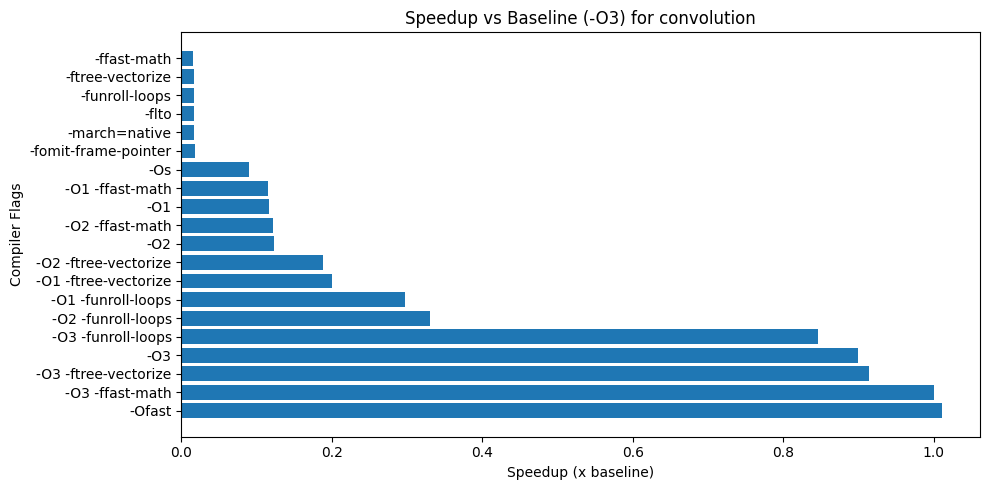

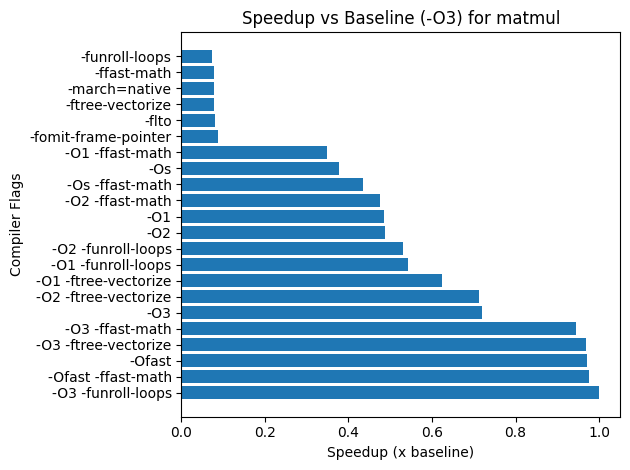

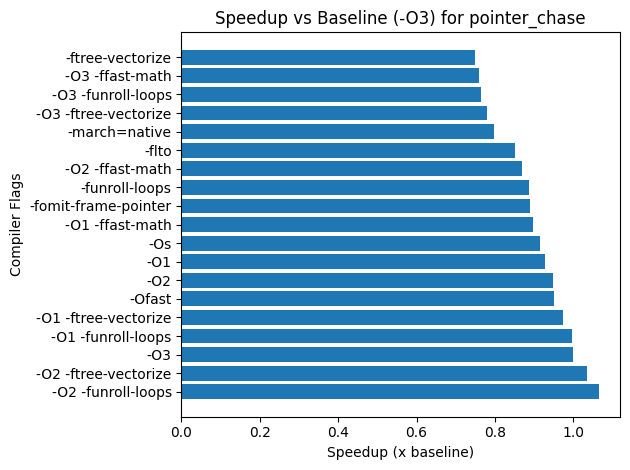

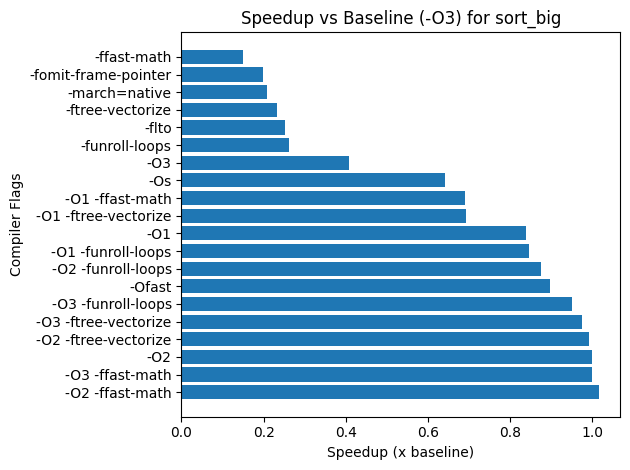

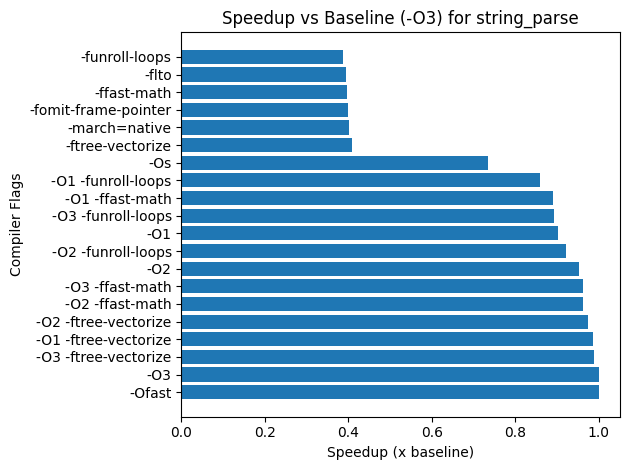

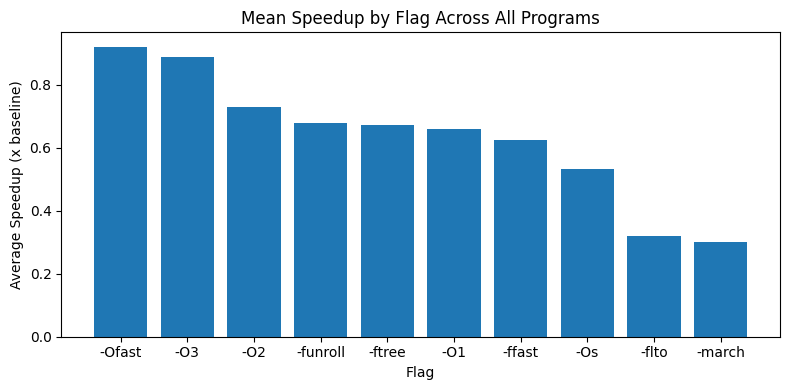


Mean speedup by flag:
    flag  mean_speedup
  -Ofast      0.921074
     -O3      0.888807
     -O2      0.728807
-funroll      0.677788
  -ftree      0.674233
     -O1      0.661183
  -ffast      0.623838
     -Os      0.531830
   -flto      0.318917
  -march      0.300521


In [1]:
# Phase 2: Compiler Flag Performance Analysis Notebook

import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Load and prepare data ===
with open('results.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"Loaded {len(df)} records from results.json")

# Extract program name (without .cpp)
df['program'] = df['src'].str.replace('.cpp', '', regex=False)

# Compute average or median runtime per (program, flags)
df['runtime'] = df['median_time']

# === Establish baselines ===
# We'll pick baseline as -O3 for each program if it exists, else -O2
base_times = (
    df[df['flags'].str.contains('-O3')]
    .groupby('program')['runtime']
    .min()
    .to_dict()
)

def get_baseline(prog):
    return base_times.get(prog, None)

df['baseline_runtime'] = df['program'].apply(get_baseline)

# Compute speedup (ratio baseline / current)
df['speedup'] = df['baseline_runtime'] / df['runtime']

# === Show best flags per program ===
best_flags = (
    df.loc[df.groupby('program')['runtime'].idxmin(), ['program', 'flags', 'runtime', 'speedup']]
    .sort_values('program')
)
print("\nBest flag combos per program:")
print(best_flags.to_string(index=False))

# === Visualization section ===
plt.figure(figsize=(10, 5))
for prog, sub in df.groupby('program'):
    sub_sorted = sub.sort_values('speedup', ascending=False)
    plt.barh(sub_sorted['flags'], sub_sorted['speedup'], label=prog)
    plt.title(f"Speedup vs Baseline (-O3) for {prog}")
    plt.xlabel('Speedup (x baseline)')
    plt.ylabel('Compiler Flags')
    plt.tight_layout()
    plt.show()

# === Aggregated trends ===
# Mean speedup per flag substring
import numpy as np

flag_perf = {}
for flag in ['-O1', '-O2', '-O3', '-Ofast', '-Os', '-flto', '-march', '-funroll', '-ftree', '-ffast']:
    mask = df['flags'].str.contains(flag)
    if mask.any():
        flag_perf[flag] = np.mean(df.loc[mask, 'speedup'])

flag_df = pd.DataFrame(list(flag_perf.items()), columns=['flag', 'mean_speedup']).sort_values('mean_speedup', ascending=False)

plt.figure(figsize=(8,4))
plt.bar(flag_df['flag'], flag_df['mean_speedup'])
plt.title('Mean Speedup by Flag Across All Programs')
plt.xlabel('Flag')
plt.ylabel('Average Speedup (x baseline)')
plt.tight_layout()
plt.show()

print("\nMean speedup by flag:")
print(flag_df.to_string(index=False))
